<a href="https://colab.research.google.com/github/sheikhmishi2001-commits/movie_recoomendation_project/blob/main/Movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
%matplotlib inline


In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity


In [13]:
def load_movielens(ratings_path="ratings.csv", movies_path="movies.csv"):
    ratings = pd.read_csv(ratings_path)
    movies = pd.read_csv(movies_path)
    titles = dict(zip(movies['movieId'], movies['title']))
    return ratings, titles

In [4]:
def leave_one_out_split(df):
    df = df.sort_values(['userId','timestamp'])
    last_idx = df.groupby('userId').tail(1).index
    test = df.loc[last_idx]
    train = df.drop(last_idx)
    return train.reset_index(drop=True), test.reset_index(drop=True)


In [5]:
def build_interaction_matrix(df):
    users = sorted(df['userId'].unique())
    items = sorted(df['movieId'].unique())
    u_to_idx = {u:i for i,u in enumerate(users)}
    i_to_idx = {m:i for i,m in enumerate(items)}
    rows = df['userId'].map(u_to_idx).values
    cols = df['movieId'].map(i_to_idx).values
    data = df['rating'].values.astype(float)
    mat = csr_matrix((data, (rows, cols)), shape=(len(users), len(items)))
    return mat, u_to_idx, i_to_idx

In [19]:
def user_based_scores(R):
    # dense_output=True -> gives ndarray, avoids COO issues
    sim = cosine_similarity(R, dense_output=True)
    denom = np.abs(sim).sum(axis=1).reshape(-1,1) + 1e-8
    preds = sim.dot(R.toarray()) / denom
    return preds

def item_based_scores(R):
    sim_items = cosine_similarity(R.T, dense_output=True)
    denom = np.abs(sim_items).sum(axis=1).reshape(1,-1) + 1e-8
    preds = R.toarray().dot(sim_items) / denom
    return preds


In [20]:
def recommend_user_cf(R, train_df, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k=10):
    preds = user_based_scores(R)
    seen = {u:set(g['movieId']) for u,g in train_df.groupby('userId')}
    recs = {}
    for u_idx in range(R.shape[0]):
        u = idx_to_u[u_idx]
        scores = preds[u_idx]   # already ndarray
        unseen = [i for i in range(R.shape[1]) if idx_to_i[i] not in seen[u]]
        ranking = sorted(unseen, key=lambda j: scores[j], reverse=True)[:k]
        recs[u] = [idx_to_i[j] for j in ranking]
    return recs

def recommend_item_cf(R, train_df, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k=10):
    preds = item_based_scores(R)
    seen = {u:set(g['movieId']) for u,g in train_df.groupby('userId')}
    recs = {}
    for u_idx in range(R.shape[0]):
        u = idx_to_u[u_idx]
        scores = preds[u_idx]   # already ndarray
        unseen = [i for i in range(R.shape[1]) if idx_to_i[i] not in seen[u]]
        ranking = sorted(unseen, key=lambda j: scores[j], reverse=True)[:k]
        recs[u] = [idx_to_i[j] for j in ranking]
    return recs

In [21]:
# Matrix Factorization (SVD)
# ======================

def svd_mf_scores(R, rank=50):
    user_means = np.array(R.sum(axis=1)).flatten() / (R!=0).sum(axis=1).A1
    user_means = np.nan_to_num(user_means, nan=0.0)
    R_centered = R.copy().astype(float)
    for i in range(R.shape[0]):
        start, end = R_centered.indptr[i], R_centered.indptr[i+1]
        R_centered.data[start:end] -= user_means[i]
    k = min(rank, min(R.shape)-1)
    U, s, Vt = svds(R_centered, k=k)
    S = np.diag(s)
    preds = U @ S @ Vt
    preds = preds + user_means.reshape(-1,1)
    return preds

def recommend_svd(R, train_df, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k=10, rank=50):
    preds = svd_mf_scores(R, rank=rank)
    seen = {u:set(g['movieId']) for u,g in train_df.groupby('userId')}
    recs = {}
    for u_idx in range(R.shape[0]):
        u = idx_to_u[u_idx]
        # preds from svd_mf_scores is already a dense array, no need for .A1
        scores = preds[u_idx]
        unseen = [i for i in range(R.shape[1]) if idx_to_i[i] not in seen[u]]
        ranking = sorted(unseen, key=lambda j: scores[j], reverse=True)[:k]
        recs[u] = [idx_to_i[j] for j in ranking]
    return recs
print('done')

done


In [22]:
# Evaluation
# ======================

def precision_at_k(recs, test_df, k=10):
    hits, total = 0, 0
    gt = dict(zip(test_df['userId'], test_df['movieId']))
    for u, rec in recs.items():
        if u in gt:
            total += 1
            hits += int(gt[u] in rec[:k])
    return hits / max(total, 1)

def evaluate_all(R, train, test, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k=10):
    results = []
    ub = recommend_user_cf(R, train, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k)
    results.append(("User-CF", precision_at_k(ub, test, k)))
    ib = recommend_item_cf(R, train, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k)
    results.append(("Item-CF", precision_at_k(ib, test, k)))
    sv = recommend_svd(R, train, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k)
    results.append(("SVD-MF", precision_at_k(sv, test, k)))
    return pd.DataFrame(results, columns=["Model","Precision@K"])

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute accuracy, precision, recall for Top-K
def evaluate_metrics(recs, test_df, k=10):
    gt = dict(zip(test_df['userId'], test_df['movieId']))
    hits, total, all_preds = 0, 0, []
    for u, rec in recs.items():
        if u in gt:
            total += 1
            hit = int(gt[u] in rec[:k])
            hits += hit
            all_preds.append((u, hit))
    accuracy = hits / max(total,1)
    precision = hits / (total * k)  # average precision across all users
    recall = hits / max(total,1)    # same as accuracy (since 1 true item per user)
    return accuracy, precision, recall, all_preds

# Full evaluation with visualizations
def evaluate_and_visualize(R, train, test, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k=10):
    models = {
        "User-CF": recommend_user_cf(R, train, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k),
        "Item-CF": recommend_item_cf(R, train, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k),
        "SVD-MF":  recommend_svd(R, train, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k)
    }

    results = []
    confusion_data = {}
    for name, recs in models.items():
        acc, prec, rec, preds = evaluate_metrics(recs, test, k)
        results.append((name, acc, prec, rec))
        confusion_data[name] = preds

    df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall"])
    print("\nEvaluation Results:\n", df)

    # --- Bar chart of metrics ---
    df.set_index("Model")[["Accuracy","Precision","Recall"]].plot(kind="bar", figsize=(8,5))
    plt.title(f"Evaluation Metrics @K={k}")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.show()

    # --- Confusion matrix heatmaps ---
    for name, preds in confusion_data.items():
        y_true = [1]*len(preds)   # each user has exactly 1 ground-truth item
        y_pred = [p for _,p in preds]  # 1=hit, 0=miss
        cm = np.zeros((2,2), dtype=int)
        for t,p in zip(y_true,y_pred):
            cm[t][p] += 1
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Miss","Hit"], yticklabels=["True","False"])
        plt.title(f"Confusion Matrix – {name}")
        plt.ylabel("Ground Truth")
        plt.xlabel("Prediction")
        plt.show()


Train size: (100226, 4) Test size: (610, 4)

Evaluation Results:
      Model  Accuracy  Precision    Recall
0  User-CF  0.059016   0.005902  0.059016
1  Item-CF  0.006557   0.000656  0.006557
2   SVD-MF  0.060656   0.006066  0.060656


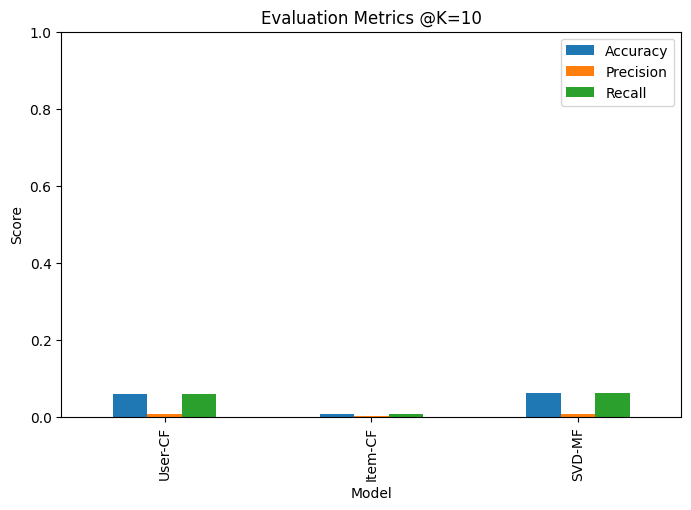

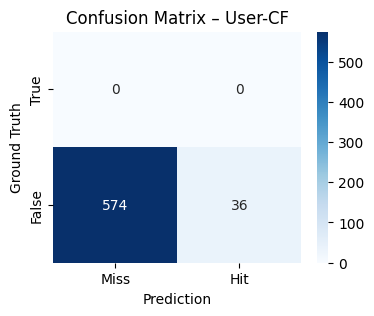

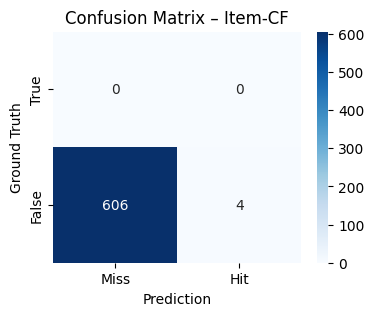

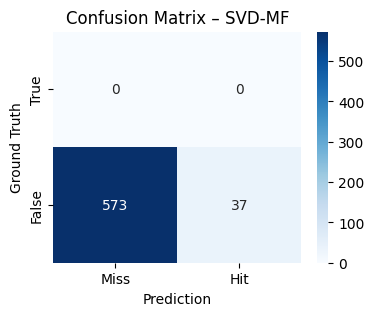


Recommendations for User 1: ['Shawshank Redemption, The (1994)', 'Terminator 2: Judgment Day (1991)', 'Godfather, The (1972)', 'Sixth Sense, The (1999)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)']


In [28]:
if __name__ == "__main__":
    ratings, titles_map = load_movielens("ratings.csv", "movies.csv")
    train, test = leave_one_out_split(ratings)
    R_train, u_to_idx, i_to_idx = build_interaction_matrix(train)
    idx_to_u = {i:u for u,i in u_to_idx.items()}
    idx_to_i = {i:m for m,i in i_to_idx.items()}

    print("Train size:", train.shape, "Test size:", test.shape)

    evaluate_and_visualize(R_train, train, test, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k=10)

    # Example: Recommend for a specific user
    target_user = 1
    recs = recommend_user_cf(R_train, train, u_to_idx, i_to_idx, idx_to_u, idx_to_i, k=5)[target_user]
    rec_titles = [titles_map.get(m, str(m)) for m in recs]
    print(f"\nRecommendations for User {target_user}: {rec_titles}")